# Data Importing and First Lookup

In [1]:
import pandas as pd 
import numpy as np
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import os

os.chdir("..")
from utils import null_checker, countplot_annot_hue
from plotly.subplots import make_subplots

In [2]:
sns.set(style='darkgrid', palette='muted')

In [3]:
os.chdir("data")
df = pd.read_csv("Mall_Customers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.drop("CustomerID", axis=1, inplace=True)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


# EDA

In [5]:
fig = px.histogram(
    df, x="Gender", histfunc="count",
    title="Gender Distribution"
)
fig.update_xaxes(type="category")
fig.show()

In [6]:
fig = px.histogram(
    df, x="Age", nbins=10, marginal="box",
    title="Age Distribution"
)
fig.show()

In [7]:
fig = px.histogram(df, x="Age", nbins=10, marginal="box", facet_col="Gender")
fig.show()

In [8]:
import scipy.stats as st

ttest = st.ttest_ind(
    df.loc[df["Gender"]=="Male", "Age"],
    df.loc[df["Gender"]=="Female", "Age"]
)
print("T-test p-value :", ttest.pvalue)

T-test p-value : 0.391890737788257


In [9]:
fig = px.histogram(df, x="Annual Income (k$)", marginal="box",
title="Annual Income Distribution")
fig.show()

In [10]:
fig = px.histogram(df, x="Annual Income (k$)", marginal="box", facet_col="Gender")
fig.show()

In [11]:
ttest = st.ttest_ind(
    df.loc[df["Gender"]=="Male", "Annual Income (k$)"], 
    df.loc[df["Gender"]=="Female", "Annual Income (k$)"]
)
print("T-test p-value :", ttest.pvalue)

T-test p-value : 0.42755249399927864


In [12]:
fig = px.histogram(df, x="Spending Score (1-100)", marginal="box",
title="Spending Score Distribution")
fig.show()

In [13]:
fig = px.histogram(df, x="Spending Score (1-100)", marginal="box", facet_col="Gender")
fig.show()

In [14]:
ttest = st.ttest_ind(
    df.loc[df["Gender"]=="Male", "Spending Score (1-100)"],
    df.loc[df["Gender"]=="Female", "Spending Score (1-100)"]
)
print("T-test p-value :", ttest.pvalue)

T-test p-value : 0.4137446589852176


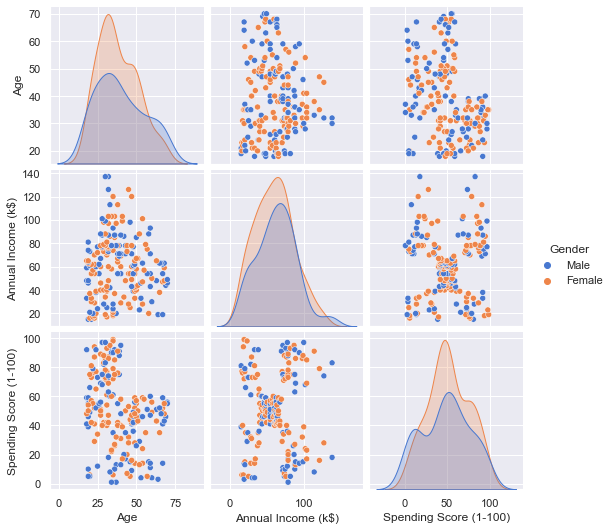

In [15]:
sns.pairplot(df, hue="Gender")

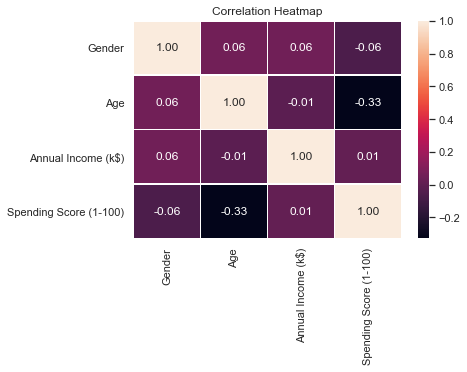

In [16]:
df["Gender"] = df["Gender"].replace("Male", 1).replace("Female", 0)

plt.figure()
sns.heatmap(df.corr(), annot=True, linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Modeling

In [17]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


## K-means

In [18]:
from sklearn.cluster import KMeans

km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(df)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

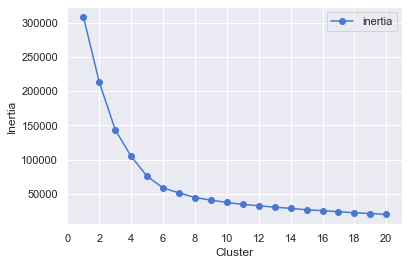

In [19]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

In [20]:
km = KMeans(n_clusters=5, random_state=42)
km = km.fit(df)

df['kmeans'] = km.predict(df)

In [21]:
fig = px.scatter(
    df, x="Annual Income (k$)",
    y="Spending Score (1-100)",
    color="kmeans"
)
fig.update_layout(
    title="K-means clustering (5 clusters)",
    coloraxis_showscale=False
)
fig.show()

## Mean Shift

In [22]:
from sklearn.cluster import MeanShift

mshift = MeanShift(bandwidth=10)
mshift.fit(df)
df["mshift"] = mshift.predict(df)

In [23]:
fig = px.scatter(
    df, x="Annual Income (k$)",
    y="Spending Score (1-100)",
    color="mshift"
)
fig.update_layout(
    title="MeanShift clustering",
    coloraxis_showscale=False
)
fig.show()

## Agglomerative Clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=5, linkage='ward', compute_full_tree=True)
ag = ag.fit(df)
df['agglom'] = ag.fit_predict(df)

In [25]:
fig = px.scatter(
    df, x="Annual Income (k$)",
    y="Spending Score (1-100)",
    color="agglom"
)
fig.update_layout(
    title="Agglomerative clustering (5 clusters)",
    coloraxis_showscale=False
)
fig.show()

## DBSCAN

In [26]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=12, min_samples=3)
dbs.fit(df)
df["dbscan"] = dbs.fit_predict(df)

In [27]:
fig = px.scatter(
    df, x="Annual Income (k$)",
    y="Spending Score (1-100)",
    color="dbscan"
)
fig.update_layout(
    title="DBSCAN clustering",
    coloraxis_showscale=False
)
fig.show()